In [2]:
#!pip install openpyxl pyarrow

In [50]:
import gc

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

# 1. Первичный анализ данных

1.1 Проверить уникальность id в полисах и убытках \
1.2 Подтянуть рисковые факторы и характеристики от полисов к убыткам \
1.3 Провести агрегацию выплат до убытков \
1.4 Подтянуть количество и сумму убытков к каждому полису \
1.5 Притянуть к полисам и убыткам – количество водителей, возраст самого молодого, стаж водителя с самым маленьким стажем. \
1.6 Провести проверки данных. Это творческое задание. Примеры проверок – дата начала полиса больше даты окончания полиса,дата убытка между датой начала и окончания полиса и т.д. \
1.7 Построить распределения количества убытков и размера убытка – посмотреть средние, минимальные и максимальные значения, перцентили. \
1.8 Рассчитать экспозицию и заработанную премию для календарного анализа \
1.9 Отдельно для календарного и андеррайтингово подходов (для убытков|тяжесть и полисов|частота) посмотреть по каждому фактору: \
1.9.1 заполненность факторов, построить распределения значений фактора (для каждого фактора) в портфеле (по таблице с полисами) \
1.9.2 построить графики количества убытков/тяжести убытков в зависимости от значений фактора, для каждого уровня фактора оценить дисперсию количества и тяжести; \
1.9.3 проанализировать устойчивость одномерных распределений по годам (убытка, заключения полиса)


In [11]:
df_claim = pd.read_excel('data/claim_reestr.xlsx')
df_polis = pd.read_excel('data/polis_reestr.xlsx')
df_drivers = pd.read_excel('data/drivers_reestr.xlsx')
df_kladr = pd.read_excel('data/kladr_ref.xlsx')

In [4]:
df_claim.sample(5)

,POLIS_ID,LOSS_ID,DTP_DT,CLAIM_DT,PAY_ID,PAY_AMT,PAY_DT,DAMAGE_TYPE,IS_ALCHO_DMG,IS_DISAPPEAR,EURO_PROTOCOL
2457,22570,600,13.08.2018,15.08.2018,730,25099.21,02.10.2018,1,0,0,0
2310,83788,2381,12.10.2019,15.10.2019,2849,81878.55,16.01.2020,1,0,0,0
4194,5452,830,21.09.2018,04.10.2018,1007,143717.39,30.10.2018,1,0,0,0
5023,81003,1254,25.11.2019,27.11.2019,1530,37182.43,18.02.2020,1,0,0,1
2107,86443,3254,11.10.2018,18.10.2018,3918,31653.04,20.11.2018,1,0,0,1


In [5]:
df_polis.sample(5)

,CREATE_DT,POLIS_ID,START_DT,END_DT,PREMIUM,DISSOLUTION_DT,VIN,CAR_ISSUE,CAR_DIAG_DT,PERS_POLIS_OWN,...,CAR_SEATS_CNT,USE_PURPOSE_FLG,REG_COUNTRY_FLG,START1,END1,START2,END2,START3,END3,hash_vin
12491,2018-04-04 00:00:00,12492,2018-04-05 00:00:00,2019-04-04 00:00:00,5188.68,NaN,899ea0798290d7f24029a7fd8630ce2327e7d40cbcc6f2...,2005.0,2019-03-15 00:00:00,FF824828028C56B273A04975A1425B681C6B93EB925CDD...,...,NaN,1,1,2018-04-05 00:00:00,2019-04-04 00:00:00,NaN,NaN,NaN,NaN,899ea0798290d7f24029a7fd8630ce2327e7d40cbcc6f2...
86741,2019-08-30 00:00:00,86742,2019-09-04 00:00:00,2020-09-03 00:00:00,6325.25,NaN,dd06cdba2cefe30aeb865b37173bee08bb592a8bfc292d...,2014.0,2019-08-30 00:00:00,FE8752A1088570F21989305BB1DD16317FB2883C16AD10...,...,NaN,1,1,2019-09-04 00:00:00,2020-09-03 00:00:00,NaN,NaN,NaN,NaN,dd06cdba2cefe30aeb865b37173bee08bb592a8bfc292d...
87964,2019-11-02 00:00:00,87965,2019-11-06 00:00:00,2020-11-05 00:00:00,4234.39,NaN,ca07165b939489847a11d9bd6065d9687b79eabbc20c00...,2013.0,NaN,E9C15EA71911DCE7CA5B82C922B665BB9440BECE96B010...,...,NaN,1,1,2019-11-06 00:00:00,2020-11-05 00:00:00,NaN,NaN,NaN,NaN,ca07165b939489847a11d9bd6065d9687b79eabbc20c00...
46284,2019-07-05 00:00:00,46285,2019-07-09 00:00:00,2020-07-08 00:00:00,3763.52,NaN,b483ee211ae39d738e0a83e947e640ffeeb6f5450b7095...,2011.0,NaN,142EB2610820746D4CFE3F4193F56920667B01997A4D5B...,...,0.0,1,1,2019-07-09 00:00:00,2020-07-08 00:00:00,NaN,NaN,NaN,NaN,b483ee211ae39d738e0a83e947e640ffeeb6f5450b7095...
84146,2018-07-06 00:00:00,84147,2018-07-07 00:00:00,2019-07-06 00:00:00,4871.59,NaN,4b07af5778a9b8d3c19536c7e22d66ac93b97bef44ddd7...,2011.0,2019-06-19 00:00:00,DCEBF9E7D2B30664339827B487A58BE47726B97E50F9A9...,...,NaN,1,1,2018-07-07 00:00:00,2019-07-06 00:00:00,NaN,NaN,NaN,NaN,4b07af5778a9b8d3c19536c7e22d66ac93b97bef44ddd7...


In [6]:
df_drivers.sample(5)

,POLIS_ID,DRIVER_HASH,DRIVER_AGE,DRIVER_EXP,BONUS_MALUS
83995,51919,A05D8AE9FCBE443630186BD86E246E1F3E354943A31055...,53,34.0,0.70
44245,27384,21C57DFC837B50EF1FFE17EACE92D5B5E612660AEEAC06...,39,10.0,0.50
80431,49698,51B0382C4AB21C711DA5AC2DC140A74DD079B83B802E56...,34,14.0,0.65
87945,54392,35EF6DE27234157008AD53630BFB11766DB443994E3E97...,49,26.0,0.55
17347,10654,C31DC3F3C4FAB8CF9A13B09338246581731D539CD0E9FB...,47,17.0,0.70


In [7]:
df_kladr.sample(5)

,kladr_code,tpi,fo,fo_tpi
1022,24017000,Красноярский край - Прочие,Сибирский ФО,Сибирский ФО: Красноярский край - Прочие
2781,68008000,Тамбовская область - Прочие,Центральный ФО,Центральный ФО: Тамбовская область - Прочие
468,4000001,Горно-Алтайск,Сибирский ФО,Сибирский ФО: Горно-Алтайск
405,35017000,Вологодская область - Прочие,Северо-Западный ФО,Северо-Западный ФО: Вологодская область - Прочие
1381,50000023,Московская область,Центральный ФО,Центральный ФО: Московская область


### 1.1 Проверить уникальность id в полисах и убытках

In [9]:
print(f'Процент уникальных id полисов в реестре выплат: {df_claim["POLIS_ID"].nunique() / len(df_claim) * 100}')
print(f'Процент уникальных id полисов в реестре полисов: {df_polis["POLIS_ID"].nunique() / len(df_polis) * 100}')
print(f'Процент уникальных id полисов в реестре водителей: {df_drivers["POLIS_ID"].nunique() / len(df_drivers) * 100}')
print(f'Процент уникальных id убытков: {df_claim["PAY_ID"].nunique() / len(df_claim) * 100}')

Процент уникальных id полисов в реестре выплат: 76.55517854257555
Процент уникальных id полисов в реестре полисов: 100.0
Процент уникальных id полисов в реестре водителей: 58.260494340397095
Процент уникальных id убытков: 100.0


### 1.2 Подтянуть рисковые факторы и характеристики от полисов к убыткам

In [12]:
df_claim_with_polis = pd.merge(df_claim, df_polis, on='POLIS_ID', how='left')

df_claim_with_polis.sample(5)

,POLIS_ID,LOSS_ID,DTP_DT,CLAIM_DT,PAY_ID,PAY_AMT,PAY_DT,DAMAGE_TYPE,IS_ALCHO_DMG,IS_DISAPPEAR,...,CAR_SEATS_CNT,USE_PURPOSE_FLG,REG_COUNTRY_FLG,START1,END1,START2,END2,START3,END3,hash_vin
5341,115071,1289,27.08.2019,27.08.2019,1571,27079.84,13.09.2019,1,0,0,...,NaN,1,1,2018-10-20 00:00:00,2019-10-19 00:00:00,NaN,NaN,NaN,NaN,0c9bcf4f48c9de961b52930c7c9bfa45429480374a4c5d...
709,100143,1513,04.09.2018,10.09.2018,1829,57938.01,15.11.2018,1,0,0,...,NaN,1,1,2018-07-14 00:00:00,2019-07-13 00:00:00,NaN,NaN,NaN,NaN,6c5fb697f85fc7aee20db92f2c908a862520976341f8fb...
5759,105849,1747,29.07.2019,05.08.2019,2103,26960.77,22.08.2019,1,0,0,...,NaN,5,1,2018-07-31 00:00:00,2019-07-30 00:00:00,NaN,NaN,NaN,NaN,7878cd5d271b4f1abd9e1a22dca574c56c3d4b59e513a3...
5900,62693,5060,30.03.2018,17.06.2019,6054,182938.42,17.07.2019,2,0,0,...,NaN,1,1,2018-01-11 00:00:00,2019-01-10 00:00:00,NaN,NaN,NaN,NaN,NaN
4294,76642,3935,22.02.2019,27.02.2019,4718,82159.98,14.03.2019,1,0,0,...,NaN,1,1,2018-12-18 00:00:00,2019-12-17 00:00:00,NaN,NaN,NaN,NaN,NaN


В объединенном датафрейме получилось 37 столбцов. Мы объединили данные так, чтобы ни для какого убытка не был потерян полис, с которым этот убыток связан. То есть в объединенном датафрейме все убытки уникальные, а полисы могут повторяться.

### 1.3 Провести агрегацию выплат до убытков (??)

**Дата убытка - это CLAIM_DT или DTP_DT??**

In [13]:
# df_claim_with_polis['DTP_DT'] = pd.to_datetime(df_claim_with_polis['DTP_DT'], dayfirst=True)
# df_claim_with_polis['PAY_DT'] = pd.to_datetime(df_claim_with_polis['PAY_DT'], dayfirst=True)
# df_claim_with_polis['PAY_BEFORE_LOSS'] = df_claim_with_polis['PAY_DT'] < df_claim_with_polis['DTP_DT']
# print(f"Количество выплат до убытков: {df_claim_with_polis['PAY_BEFORE_LOSS'].sum()}")

df_claim_with_polis['CLAIM_DT'] = pd.to_datetime(df_claim_with_polis['CLAIM_DT'], dayfirst=True)
df_claim_with_polis['PAY_DT'] = pd.to_datetime(df_claim_with_polis['PAY_DT'], dayfirst=True)
df_claim_with_polis['PAY_BEFORE_LOSS'] = df_claim_with_polis['PAY_DT'] < df_claim_with_polis['CLAIM_DT']
print(f"Количество выплат до убытков: {df_claim_with_polis['PAY_BEFORE_LOSS'].sum()}")
df_claim_with_polis = df_claim_with_polis[~(df_claim_with_polis['PAY_DT'] < df_claim_with_polis['CLAIM_DT'])] # удалим так как это ошибки в данных

Количество выплат до убытков: 44


### 1.4 Подтянуть количество и сумму убытков к каждому полису

In [14]:
loss_counts = df_claim.groupby('POLIS_ID').size().reset_index(name='LOSS_COUNT')
loss_sums = df_claim.groupby('POLIS_ID')['PAY_AMT'].sum().reset_index(name='TOTAL_PAY_AMT')
losses = pd.merge(loss_counts, loss_sums, on='POLIS_ID')

df_polis_with_losses = pd.merge(df_polis, losses, on='POLIS_ID', how='left')
df_polis_with_losses[df_polis_with_losses['LOSS_COUNT'] > 0].sample(5)

,CREATE_DT,POLIS_ID,START_DT,END_DT,PREMIUM,DISSOLUTION_DT,VIN,CAR_ISSUE,CAR_DIAG_DT,PERS_POLIS_OWN,...,REG_COUNTRY_FLG,START1,END1,START2,END2,START3,END3,hash_vin,LOSS_COUNT,TOTAL_PAY_AMT
71962,2019-03-15 00:00:00,71963,2019-03-19 00:00:00,2020-03-18 00:00:00,7748.43,NaN,040bbc7e9909b6eb6c5e42567a805b8d30b9ff855c61da...,2000.0,2020-03-01 00:00:00,93C850020EAC5AE23D2FBD35E71673EFB8C47BCE1A0400...,...,1,2019-03-19 00:00:00,2020-03-18 00:00:00,NaN,NaN,NaN,NaN,040bbc7e9909b6eb6c5e42567a805b8d30b9ff855c61da...,1.0,11118.39
49389,2018-05-05 00:00:00,49390,2018-05-06 00:00:00,2019-05-05 00:00:00,9339.62,NaN,fe638f2558983cfe64f24f7585bcfefe8036ae76887cc7...,2006.0,2019-05-06 00:00:00,7999EA62095555361C47C47C0564EDDBD601064CC7166F...,...,1,2018-05-06 00:00:00,2019-05-05 00:00:00,NaN,NaN,NaN,NaN,fe638f2558983cfe64f24f7585bcfefe8036ae76887cc7...,1.0,400000.00
85473,2019-01-18 00:00:00,85474,2019-01-20 00:00:00,2020-01-19 00:00:00,3391.91,NaN,7be4c655ecb79abee6fe3cea4e46697a8df9e50315ac45...,2005.0,2020-01-19 00:00:00,1D67BF2183CF4DCA496398D197A113B220E11DB2E393A2...,...,1,2019-01-20 00:00:00,2020-01-19 00:00:00,NaN,NaN,NaN,NaN,7be4c655ecb79abee6fe3cea4e46697a8df9e50315ac45...,2.0,35019.84
97243,2019-03-26 00:00:00,97244,2019-04-01 00:00:00,2020-03-31 00:00:00,5914.11,NaN,59a9f388bc58cab5cba5aa492b5718d7b66c5b8b892f68...,2009.0,NaN,0D2D23976312EC0186E94F6E8953EF70DCDDE140CE5641...,...,1,2019-04-01 00:00:00,2020-03-31 00:00:00,NaN,NaN,NaN,NaN,59a9f388bc58cab5cba5aa492b5718d7b66c5b8b892f68...,1.0,18906.50
64383,2019-10-18 00:00:00,64384,2019-10-18 00:00:00,2020-10-17 00:00:00,7608.25,NaN,ee4be72634ba4cb089641bdbf3a72b8a576c53ffe75c3e...,2015.0,2020-09-25 00:00:00,3485E81A5DF7D2323A34B208010C82795BC01D26B21ED1...,...,1,2019-10-18 00:00:00,2020-10-17 00:00:00,NaN,NaN,NaN,NaN,ee4be72634ba4cb089641bdbf3a72b8a576c53ffe75c3e...,1.0,6300.29


### 1.5 Притянуть к полисам и убыткам – количество водителей, возраст самого молодого, стаж водителя с самым маленьким стажем

In [17]:
drivers_agg = df_drivers.groupby('POLIS_ID').agg(
    DRIVER_COUNT=('DRIVER_HASH', 'count'),
    MIN_DRIVER_AGE=('DRIVER_AGE', 'min'),
    MIN_DRIVER_EXP=('DRIVER_EXP', 'min'),
).reset_index()

drivers_agg

,POLIS_ID,DRIVER_COUNT,MIN_DRIVER_AGE,MIN_DRIVER_EXP
0,1,1,29,8.0
1,2,3,33,6.0
2,3,4,33,8.0
3,4,2,40,15.0
4,5,3,36,3.0
...,...,...,...,...
110708,117119,1,30,11.0
110709,117120,1,31,11.0
110710,117121,2,29,10.0
110711,117122,2,42,13.0


In [18]:
df_polis_with_losses_and_drivers = pd.merge(df_polis_with_losses, drivers_agg, on='POLIS_ID', how='left')
df_polis_with_losses_and_drivers.sample(5)

,CREATE_DT,POLIS_ID,START_DT,END_DT,PREMIUM,DISSOLUTION_DT,VIN,CAR_ISSUE,CAR_DIAG_DT,PERS_POLIS_OWN,...,START2,END2,START3,END3,hash_vin,LOSS_COUNT,TOTAL_PAY_AMT,DRIVER_COUNT,MIN_DRIVER_AGE,MIN_DRIVER_EXP
66744,2019-07-18 00:00:00,66745,2019-07-18 00:00:00,2020-07-17 00:00:00,7447.88,NaN,790e5356d738cd47d7a8258ee4cac5ca089f437401487c...,2008.0,2020-07-18 00:00:00,2A84E0595BB87C0D2C8ED38314E7811C9720A1C14A8D82...,...,NaN,NaN,NaN,NaN,790e5356d738cd47d7a8258ee4cac5ca089f437401487c...,NaN,NaN,3.0,25.0,6.0
40514,2019-09-10 00:00:00,40515,2019-09-13 00:00:00,2020-09-12 00:00:00,9712.68,NaN,6bfa3594cb599dc954aa55ff545cb3dbd7240f0901c6a4...,2017.0,2019-09-13 00:00:00,C9958EB43219537B85D0AE253A2E47ACA7493AEDA3E99D...,...,NaN,NaN,NaN,NaN,6bfa3594cb599dc954aa55ff545cb3dbd7240f0901c6a4...,NaN,NaN,2.0,28.0,8.0
91017,2018-04-19 00:00:00,91018,2018-05-07 00:00:00,2019-05-06 00:00:00,6102.88,NaN,1623aa96e14a1df1260217f0485b1840bd9d1c0fff4eba...,2012.0,NaN,CB91D2E46C3ACE1F6C11183FA2A5E20742814731CD364A...,...,NaN,NaN,NaN,NaN,1623aa96e14a1df1260217f0485b1840bd9d1c0fff4eba...,NaN,NaN,2.0,32.0,9.0
50720,2018-10-30 00:00:00,50721,2018-10-31 00:00:00,2019-10-30 00:00:00,2853.77,NaN,cd34ceeac65616eb8169fd9bb581ef78c37ea74a55906b...,2006.0,2019-10-30 00:00:00,6161AB9AC3558D2FE50B5D0D49A70AF202D48D75D69CD8...,...,NaN,NaN,NaN,NaN,cd34ceeac65616eb8169fd9bb581ef78c37ea74a55906b...,NaN,NaN,2.0,27.0,8.0
27904,2018-08-25 00:00:00,27905,2018-08-30 00:00:00,2019-08-29 00:00:00,22401.92,NaN,ff2dd6d0a56d46c1b1197fec657ae812a9b4404df21166...,2011.0,NaN,327BE41024FFD0FF49D14DDF39ED767103C6A1A646DF61...,...,NaN,NaN,NaN,NaN,ff2dd6d0a56d46c1b1197fec657ae812a9b4404df21166...,NaN,NaN,3.0,22.0,0.0


В результате выполнения двух предыдущих пунктов для каждого полиса мы получили следующие дополнительные данные: ```LOSS_COUNT, TOTAL_PAY_AMT, DRIVER_COUNT, MIN_DRIVER_AGE, MIN_DRIVER_EXP```. В случае если по полису не было убытков (и выплат), то выводится NaN.

In [96]:
df_polis_with_losses_and_drivers[~df_polis_with_losses_and_drivers['POLIS_ID'].isin(wrong_pids)].to_csv('/workspaces/BDAktuarki/data/df_with_target.csv')

### 1.6 Провести проверки данных.
Это творческое задание. Примеры проверок – дата начала полиса больше даты окончания полиса, дата убытка между датой начала и окончания полиса и т.д.

In [41]:
# Первичное преобразование типов для непустых признаков дат
for col in df_polis.columns:
    if ('_DT' in col) and (df_polis[col].isna().sum() == 0):
        print(col)
        df_polis[col] = pd.to_datetime(df_polis[col])

for col in df_claim.columns:
    if ('_DT' in col) and (df_claim[col].isna().sum() == 0):
        print(col)
        df_claim[col] = pd.to_datetime(df_claim[col], dayfirst=True)

CREATE_DT
START_DT
END_DT
DTP_DT
CLAIM_DT
PAY_DT


In [42]:
df_polis_to_j = df_polis.set_index('POLIS_ID').copy()
df_claim_to_j = df_claim.set_index('POLIS_ID').copy()
df_j_pls_clm = df_polis_to_j.join(df_claim_to_j, how='left').reset_index()
df_j_pls_clm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118574 entries, 0 to 118573
Data columns (total 37 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   POLIS_ID         118574 non-null  int64         
 1   CREATE_DT        118574 non-null  datetime64[ns]
 2   START_DT         118574 non-null  datetime64[ns]
 3   END_DT           118574 non-null  datetime64[ns]
 4   PREMIUM          118573 non-null  float64       
 5   DISSOLUTION_DT   0 non-null       float64       
 6   VIN              108264 non-null  object        
 7   CAR_ISSUE        118176 non-null  float64       
 8   CAR_DIAG_DT      78205 non-null   object        
 9   PERS_POLIS_OWN   118501 non-null  object        
 10  PERS_CAR_OWN     118574 non-null  object        
 11  KLADR_CODE       118164 non-null  float64       
 12  MULTIDRIVE_FLG   118574 non-null  int64         
 13  BONUS_MALUS      118556 non-null  float64       
 14  CAR_ENG_PWR      118

In [63]:
# Дата начала полиса больше даты окончания полиса
mask = df_polis['START_DT'] > df_polis['END_DT']
assert len(df_polis[mask]) == 0

# Дата убытка между датой начала и окончания полиса
mask_on_pay = ~df_j_pls_clm['PAY_ID'].isna()
mask_on_date_lb = df_j_pls_clm['DTP_DT'] >= df_j_pls_clm['START_DT']
mask_on_date_lb = df_j_pls_clm['DTP_DT'] <= df_j_pls_clm['END_DT']
print('Процент наблюдений среди случаев с ДТП в которых дата ДТП между датой начала и окончания', end=' ')
print(len(df_j_pls_clm[mask_on_pay & mask_on_date_lb & mask_on_date_lb]) / len(df_j_pls_clm[mask_on_pay]) * 100)

Процент наблюдений среди случаев с ДТП в которых дата ДТП между датой начала и окончания 100.0


Т.е. все верно, ошибок согласно критериям ниже в данных нет:
1. Дата начала полиса раньше его окончания
2. Дата ДТП строго меду датой начала и конца действия полиса

In [64]:
# Проверка численных признаков на положительную определенность
num_feats_polis = ['PREMIUM', 'BONUS_MALUS', 'CAR_ENG_PWR', 'CAR_WEIGHT', 'CAR_SEATS_CNT']
num_feats_drivers = ['DRIVER_AGE', 'DRIVER_EXP', 'BONUS_MALUS']
num_feats_claim = ['PAY_AMT']
num_feats_all = [num_feats_polis, num_feats_drivers, num_feats_claim]
all_dfs = {'polis_reestr': df_polis,
           'drivers_reestr': df_drivers,
           'claim_reestr': df_claim}

print('Кол-во наблюдений в каждом численном признаке равных 0')
for feat_list, df_key in zip(num_feats_all, all_dfs.keys()):
    df = all_dfs[df_key].copy()
    lens_wrong = [len(df[df[feat] == 0]) for feat in feat_list]
    print(df_key, end=': ')
    print(*zip(feat_list, lens_wrong))
print()
print('Кол-во наблюдений в каждом численном признаке со значением меньше 0')
for feat_list, df_key in zip(num_feats_all, all_dfs.keys()):
    df = all_dfs[df_key].copy()
    lens_wrong = [len(df[df[feat] < 0]) for feat in feat_list]
    print(df_key, end=': ')
    print(*zip(feat_list, lens_wrong))


Кол-во наблюдений в каждом численном признаке равных 0
polis_reestr: ('PREMIUM', 75) ('BONUS_MALUS', 0) ('CAR_ENG_PWR', 1) ('CAR_WEIGHT', 303) ('CAR_SEATS_CNT', 331)
drivers_reestr: ('DRIVER_AGE', 0) ('DRIVER_EXP', 1131) ('BONUS_MALUS', 0)
claim_reestr: ('PAY_AMT', 1)

Кол-во наблюдений в каждом численном признаке со значением меньше 0
polis_reestr: ('PREMIUM', 1) ('BONUS_MALUS', 0) ('CAR_ENG_PWR', 0) ('CAR_WEIGHT', 0) ('CAR_SEATS_CNT', 0)
drivers_reestr: ('DRIVER_AGE', 0) ('DRIVER_EXP', 2) ('BONUS_MALUS', 0)
claim_reestr: ('PAY_AMT', 0)


Ошибочными можно посчитать наличие в данных наблюдений с 0 премией и 0 значением кол-ва сидений и массы машины, запомним эти полисы и позднее удалим их так как они занимают < 0.1% в данных, по той же причине избавимся и от наблюдений в которых численные признакие принимают знач-ия меньше 0

In [77]:
wrong_pids = df_polis[(df_polis['CAR_WEIGHT'] == 0) | 
                      (df_polis['CAR_SEATS_CNT'] == 0) | 
                      (df_polis['PREMIUM'] <= 0)]['POLIS_ID'].to_list()

wrong_pids.extend(df_drivers[df_drivers['DRIVER_EXP'] < 0]['POLIS_ID'].to_list())
wrong_pids = list(set(wrong_pids))


### 1.7 Построить распределения количества убытков и размера убытка
Посмотреть средние, минимальные и максимальные значения, перцентили.

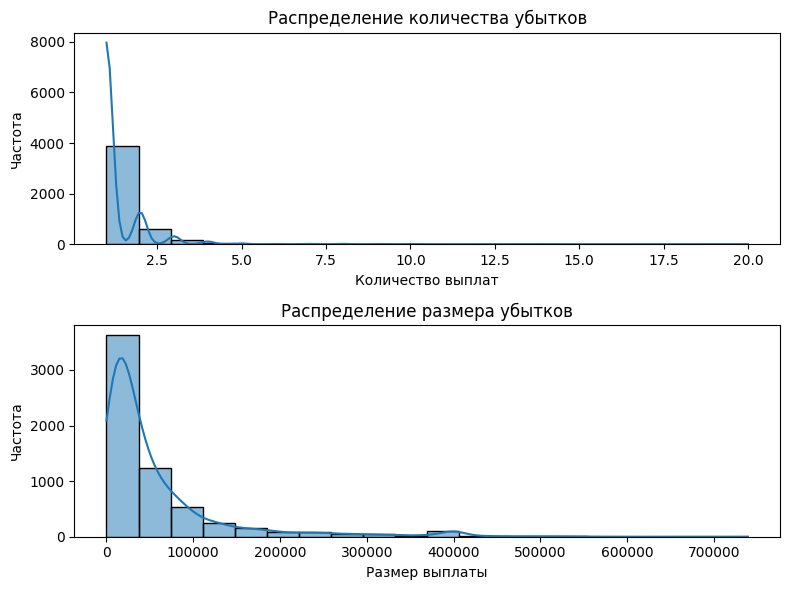

In [51]:
claims_count = df_claim['POLIS_ID'].value_counts()
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

sns.histplot(claims_count, bins=20, ax=ax[0], kde=True)
ax[0].set_title('Распределение количества убытков')
ax[0].set_xlabel('Количество выплат')
ax[0].set_ylabel('Частота')

sns.histplot(df_claim['PAY_AMT'], bins=20, ax=ax[1], kde=True)
ax[1].set_title('Распределение размера убытков')
ax[1].set_xlabel('Размер выплаты')
ax[1].set_ylabel('Частота')

plt.tight_layout()
plt.show()

In [57]:
claims_count_stats = {
    'mean': claims_count.mean(),
    'min': claims_count.min(),
    'max': claims_count.max(),
    'percentiles': claims_count.quantile([0.25, 0.5, 0.75])
}

print(
    f"Среднее количество убытков: {claims_count_stats['mean']}",
    f"Минимальное количество убытков: {claims_count_stats['min']}",
    f"Максимальное количество убытков: {claims_count_stats['max']}",
    f"Перцентили: \n{claims_count_stats['percentiles']}",
    sep="\n"
)

Среднее количество убытков: 1.3062473617560153
Минимальное количество убытков: 1
Максимальное количество убытков: 20
Перцентили: 
0.25    1.0
0.50    1.0
0.75    1.0
Name: POLIS_ID, dtype: float64


In [58]:
pay_amount_stats = {
    'mean': df_claim['PAY_AMT'].mean(),
    'min': df_claim['PAY_AMT'].min(),
    'max': df_claim['PAY_AMT'].max(),
    'percentiles': df_claim['PAY_AMT'].quantile([0.25, 0.5, 0.75])
}

print(
    f"Среднее количество убытков: {pay_amount_stats['mean']}",
    f"Минимальное количество убытков: {pay_amount_stats['min']}",
    f"Максимальное количество убытков: {pay_amount_stats['max']}",
    f"Перцентили: \n{pay_amount_stats['percentiles']}",
    sep="\n"
)

Среднее количество убытков: 56568.58933753433
Минимальное количество убытков: 0.0
Максимальное количество убытков: 739326.33
Перцентили: 
0.25    12782.04
0.50    28641.04
0.75    64658.18
Name: PAY_AMT, dtype: float64


### 1.8 Рассчитать экспозицию и заработанную премию для календарного анализа

### 1.9 Отдельно для календарного и андеррайтингово подходов (для убытков - тяжесть и полисов - частота) посмотреть по каждому фактору)

### 1.9.1 заполненность факторов, построить распределения значений фактора (для каждого фактора) в портфеле (по таблице с полисами)

### 1.9.2 построить графики количества убытков/тяжести убытков в зависимости от значений фактора, для каждого уровня фактора оценить дисперсию количества и тяжести;

### 1.9.3 проанализировать устойчивость одномерных распределений по годам (убытка, заключения полиса)

# 2. Первые модели
1. Предобработать каждуую фичу согласно способам обработки 
2. Заполнить пропуски в фичах исходя из способов заполнения 
3.	Построить ОЛМ модели тяжести и частоты. Факторы включить как бинарные.
Построить диагностические графики в разрезе факторов. 
4.	Добавить факт и предикт на индивидуальные графики:
5.	Проверить значимость факторов статистиками (F-тест, Хи-квадрат).
6.	Построить графы остатков.
7.	Сгладить возраст и построить улучшенную модель.
8.	Построить ROC-AUC, посмотреть другие метрики точности
9.	Сделать кодирование фактора регион (слайд 63 лекций).
10.	Построить ОЛМ модели с закодированным регионом.


| Имя             | Описание признаков                   | Способ обработки     | Способ заполнения Nan                 |
| --------------- | ------------------------------------ | -------------------- | ------------------------------------- |
| CREATE_DT       | Дата заключения                      | drop                 | -                                     |
| POLIS_ID        | ID полиса                            | drop                 | -                                     |
| START_DT        | Дата начала действия                 | drop                 | -                                     |
| END_DT          | Дата окончания действия              | diff START_DT (дни)  | -                                     |
| PREMIUM         | Премия полиса                        | -                    | 0                                     |
| DISSOLUTION_DT  | Дата досрочного расторжения          | drop (много пустых)  | -                                     |
| VIN             | VIN ТС                               | drop                 | -                                     |
| CAR_ISSUE       | Год выпуска ТС                       | diff START_DT (годы) | int(median)                           |
| CAR_DIAG_DT     | Дата последней диагностики ТС        | diff START_DT (дни)  | заполн. -1e9 т.к. nan может нести инф |
| PERS_POLIS_OWN  | ХЭШ страхователя                     | drop                 | -                                     |
| PERS_CAR_OWN    | ХЭШ собственника ТС                  | drop                 | -                                     |
| KLADR_CODE      | КОД КЛАДР (Классификатор адресов РФ) | drop ????            | -                                     |
| MULTIDRIVE_FLG  | Наличие ограничения на ЛДУ           | -                    | -                                     |
| BONUS_MALUS     | коэф-ент бонус малус                 | -                    | median                                |
| CAR_ENG_PWR     | Мощность ТС                          | -                    | median                                |
| TRAILER_FLG     | Наличие прицепа ТС                   | -                    | -                                     |
| CAR_WEIGHT      | Вес ТС                               | drop(много нанов)    | -                                     |
| CAR_SEATS_CNT   | Кол-во мест в ТС                     | drop(много нанов)    | -                                     |
| USE_PURPOSE_FLG | Цель использования                   | oh_encoding          | -                                     |
| REG_COUNTRY_FLG | Страна регистрации                   | oh_encoding          | -                                     |
| START1          | Период1 начало                       | diff START_DT (дни)  | median                                |
| END1            | Период1 конец                        | diff START1 (дни)    | median                                |
| START2          | Период2 начало                       | drop                 | -                                     |
| END2            | Период2 конец                        | drop                 | -                                     |
| START3          | Период3 начало                       | drop                 | -                                     |
| END3            | Период3 конец                        | drop                 | -                                     |
| DRIVER_COUNT    | Кол-во водителей в полисе            | -                    | median                                |
| MIN_DRIVER_AGE  | MIN Возраст водителя                 | -                    | median                                |
| MIN_DRIVER_EXP  | MIN Опыт водителя                    | -                    | median                                |

### Предобработка признаков

#### Трансформация признаков

In [53]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
import re

oh_enc = OneHotEncoder(drop='first')
df_to_transform = pd.read_csv('/workspaces/BDAktuarki/data/df_with_target.csv').drop('Unnamed: 0', axis=1)

cols_to_drop = ['CREATE_DT', 'POLIS_ID', 'DISSOLUTION_DT', 
                'VIN', 'PERS_POLIS_OWN', 'PERS_CAR_OWN',
                'CAR_WEIGHT', 'CAR_SEATS_CNT', 'START2', 'END2',
                'START3', 'END3', 'KLADR_CODE', 'hash_vin']
cols_to_enc = ['USE_PURPOSE_FLG', 'REG_COUNTRY_FLG']

df_to_transform.drop(cols_to_drop, axis=1, inplace=True)

# One_hot кодирование
transformer = make_column_transformer(
    (oh_enc, cols_to_enc),
    remainder='passthrough')
transformed = transformer.fit_transform(df_to_transform)

regex = re.compile(r'remainder__')
filtered = [i.replace('remainder__', '') if regex.match(i) else i.replace('onehotencoder__', '') for i in transformer.get_feature_names_out()]

transformed_df = pd.DataFrame(
    transformed, 
    columns=filtered
)

# Генерация фичей из дат
cols_to_dt = ['START_DT', 'END_DT', 'START1', 'END1', 'CAR_DIAG_DT']
for col in cols_to_dt:
    transformed_df[col] = pd.to_datetime(transformed_df[col], errors='coerce')

transformed_df['polis_length'] = (transformed_df['END_DT'] - transformed_df['START_DT']) / np.timedelta64(1, 'D')
transformed_df['carr_issue_diff'] = transformed_df['START_DT'].dt.year - transformed_df['CAR_ISSUE']
transformed_df['start1_diff'] = (transformed_df['START1'] - transformed_df['START_DT']) / np.timedelta64(1, 'D')
transformed_df['end1_diff'] = (transformed_df['END1'] - transformed_df['START1']) / np.timedelta64(1, 'D')
transformed_df['car_diag_diff'] = (transformed_df['CAR_DIAG_DT'] - transformed_df['START_DT']) / np.timedelta64(1, 'D')

transformed_df.drop(cols_to_dt, axis=1, inplace=True)

# Заполнение пропусков 
cols_to_fill_MED = ['carr_issue_diff', 'BONUS_MALUS', 'CAR_ENG_PWR',
                    'start1_diff', 'end1_diff', 'DRIVER_COUNT',
                    'MIN_DRIVER_AGE', 'MIN_DRIVER_EXP']

transformed_df[cols_to_fill_MED] = transformed_df[cols_to_fill_MED].fillna(transformed_df[cols_to_fill_MED].median())
transformed_df['PREMIUM'] = transformed_df['PREMIUM'].fillna(0)
transformed_df['car_diag_diff'] = transformed_df['car_diag_diff'].fillna(-1e9)

transformed_df.to_csv('/workspaces/BDAktuarki/data/transformed.csv')

### Разбивка на train valid test 

In [56]:
# from sklearn.model_selection import train_test_split

# df_to_split = pd.read_csv('/workspaces/BDAktuarki/data/transformed.csv').drop('Unnamed: 0', axis=1)
# df_train, df_oot = train_test_split(df_to_split, test_size=.25, shuffle=False)
# df_train, df_oos = train_test_split(df_train, test_size=.25, random_state=11)

# df_train['sample'] = 'TRAIN'
# df_oos['sample'] = 'VALID'
# df_oot['sample'] = 'TEST'

# pd.concat((df_train, df_oos, df_oot)).to_csv('final_df.csv')

### 2.1 (частично) Построить ОЛМ модели тяжести и частоты

In [151]:
df = pd.read_csv('final_df.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
df[['LOSS_COUNT', 'TOTAL_PAY_AMT']] = df[['LOSS_COUNT', 'TOTAL_PAY_AMT']].fillna(0)
df_wo_targ = df.drop(['LOSS_COUNT', 'TOTAL_PAY_AMT'], axis=1)
train = df_wo_targ['sample'] == 'TRAIN'
valid = df_wo_targ['sample'] == 'VALID'
test = df_wo_targ['sample'] == 'TEST'

X_train, X_valid, X_test = df_wo_targ[train], df_wo_targ[valid], df_wo_targ[test]
loss_cnt_train, loss_cnt_valid, loss_cnt_test = df[train]['LOSS_COUNT'], df[valid]['LOSS_COUNT'], df[test]['LOSS_COUNT']
tot_pay_train, tot_pay_valid, tot_pay_test = df[train]['TOTAL_PAY_AMT'], df[valid]['TOTAL_PAY_AMT'], df[test]['TOTAL_PAY_AMT']

/tmp/ipykernel_4512/1738712549.py:1: DtypeWarning: Columns (24,25,26,27) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('final_df.csv').drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)


In [152]:
print(f'Кол-во уникальных значений в частотности ДТП на полис: {len(df["LOSS_COUNT"].unique())}')
print(f'Кол-во уникальных значений в сумме выплат на полис: {len(df["TOTAL_PAY_AMT"].unique())}')

Кол-во уникальных значений в частотности ДТП на полис: 18
Кол-во уникальных значений в сумме выплат на полис: 4669


На основнании того что множество значений частотности ДТП на полис принимает всего 18 значений в качестве априорного распределения ошибок для GLM возьмем Пуассоновское распределение 

In [126]:
# !pip install statsmodels

In [154]:
# import statsmodels.api as sm
# X_train = X_train.drop(['CREATE_DT', 'POLIS_ID', 'START_DT', 'END_DT', 'DISSOLUTION_DT',
#               'VIN', 'PERS_POLIS_OWN', 'CAR_DIAG_DT', 'PERS_CAR_OWN',
#               'START1', 'END1', 'START2', 'END2', 'START3', 'END3', 'hash_vin',
#               'sample'], axis=1).fillna(0)

# poison_model = sm.GLM(loss_cnt_train, sm.add_constant(X_train),
#                       family=sm.families.Poisson())
# res = poison_model.fit()
# print(res.summary())


### 2.5	Сгладить возраст и построить улучшенную модель.

In [2]:
df = pd.read_csv('final_df.csv')
df['MIN_DRIVER_AGE']

/tmp/ipykernel_7586/3477818880.py:1: DtypeWarning: Columns (23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('final_df.csv')


0         50.0
1         31.0
2         23.0
3         31.0
4         55.0
          ... 
117118     NaN
117119    30.0
117120    55.0
117121    41.0
117122    29.0
Name: MIN_DRIVER_AGE, Length: 117123, dtype: float64

<Axes: >

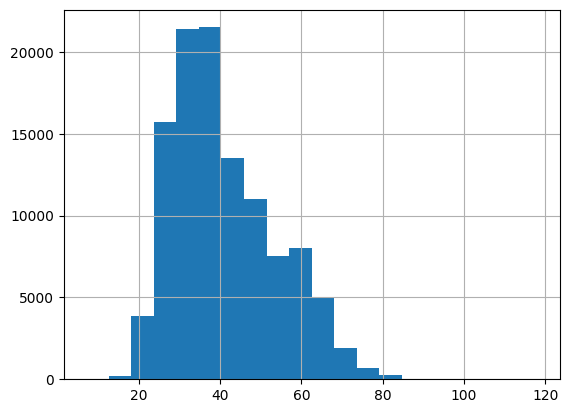

In [4]:
df['MIN_DRIVER_AGE']